In [1]:
# includes
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# for data handling
import pandas as pd
import os


In [43]:
# gleichung 

def flux_pd_lactol(vmax, km, s):
    return vmax * s / (km + s)

def ode_pd_lactol(t, y, vmax, km):
    s,p = y
    dsdt = -flux_pd_lactol(vmax, km, s)
    dpdt = flux_pd_lactol(vmax, km, s)
    
    return [dsdt, dpdt]

In [2]:
# import data

data = pd.read_csv('data/mm_nad_lactol.csv', sep=',')

nad = data['x'].values
v11 = data['y'].values 

data = pd.read_csv('data/mm_pdiol_lactol.csv', sep=',')
pd = data['x'].values
v12 = data['y'].values


Geschätzte Parameter:
Vmax = 0.0698 ± 0.0020
Km = 2.1933 ± 0.1689
Vmax = 0.0517 ± 0.0035
Km = 80.7741 ± 18.7092


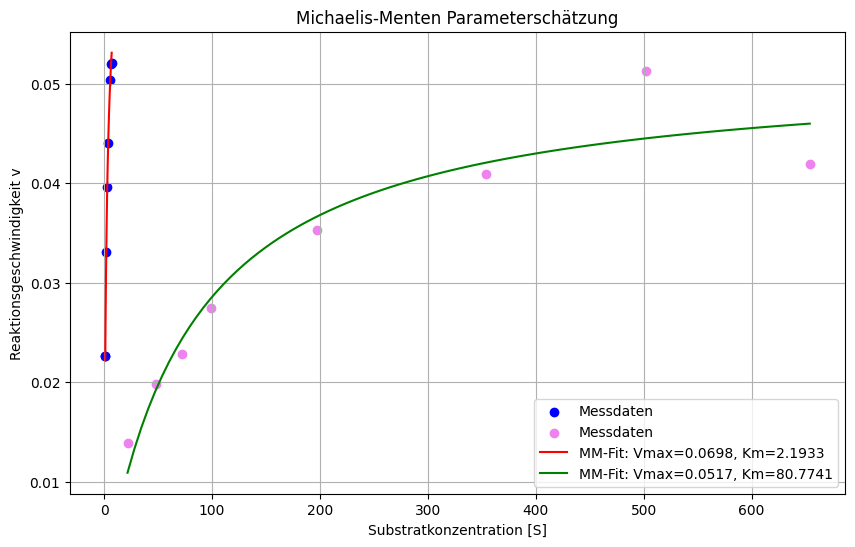

In [3]:
# optimierung

from scipy.optimize import curve_fit

def mm_equation(s, vmax, km):
    return vmax * s / (km + s)

params1, pcov1 = curve_fit(mm_equation, nad, v11, p0=[1.0, 1.0])
vmax_est1, km_est1 = params1

params2, pcov2 = curve_fit(mm_equation, pd, v12, p0=[1.0, 1.0])
vmax_est2, km_est2 = params2


# Standardfehler berechnen
perr1 = np.sqrt(np.diag(pcov1))
perr2 = np.sqrt(np.diag(pcov2))

# Ergebnisse anzeigen
print(f"Geschätzte Parameter:")
print(f"Vmax = {vmax_est1:.4f} ± {perr1[0]:.4f}")
print(f"Km = {km_est1:.4f} ± {perr1[1]:.4f}")

print(f"Vmax = {vmax_est2:.4f} ± {perr2[0]:.4f}")
print(f"Km = {km_est2:.4f} ± {perr2[1]:.4f}")


# Vorhersagen mit den geschätzten Parametern plotten
s_line1 = np.linspace(min(nad), max(nad), 100)
s_line2 = np.linspace(min(pd), max(pd), 100)

v_line1 = mm_equation(s_line1, vmax_est1, km_est1)
v_line2 = mm_equation(s_line2, vmax_est2, km_est2)

plt.figure(figsize=(10, 6))
plt.scatter(nad, v11, color='blue', label='Messdaten')
plt.scatter(pd, v12, color='violet', label='Messdaten')
plt.plot(s_line1, v_line1, 'r-', label=f'MM-Fit: Vmax={vmax_est1:.4f}, Km={km_est1:.4f}')
plt.plot(s_line2, v_line2, 'g-', label=f'MM-Fit: Vmax={vmax_est2:.4f}, Km={km_est2:.4f}')
plt.xlabel('Substratkonzentration [S]')
plt.ylabel('Reaktionsgeschwindigkeit v')
plt.title('Michaelis-Menten Parameterschätzung')
plt.legend()
plt.grid(True)
plt.show()


Monte Carlo Fehleranalyse:
Vmax = 0.0698 ± 0.0087
Km = 2.1933 ± 0.6495
Vmax = 0.0517 ± 0.0043
Km = 80.7741 ± 18.4926


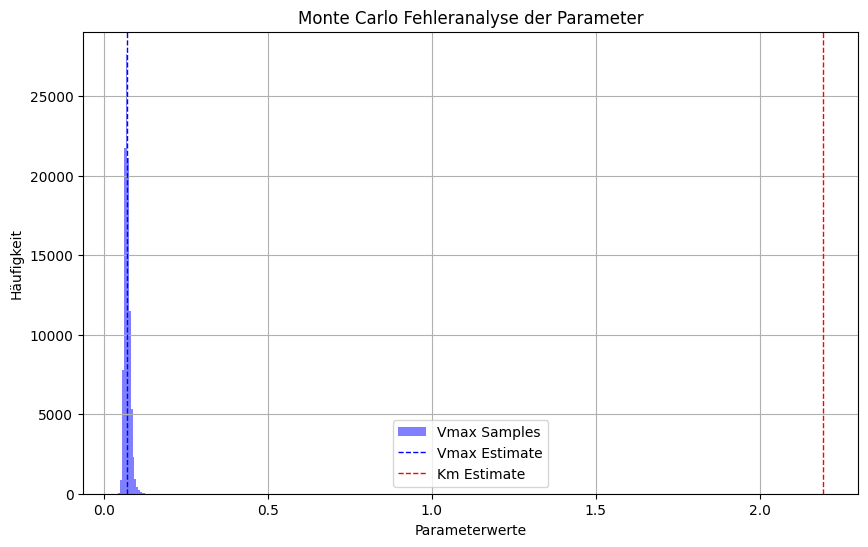

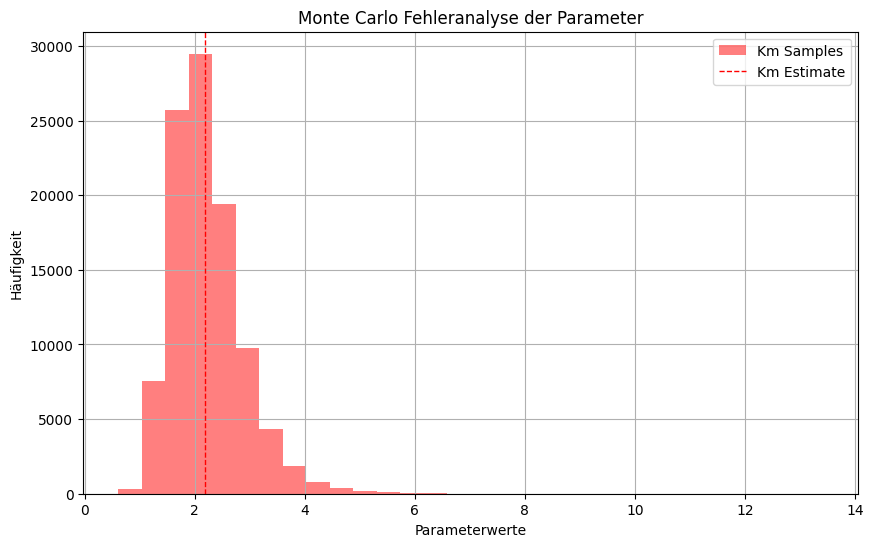

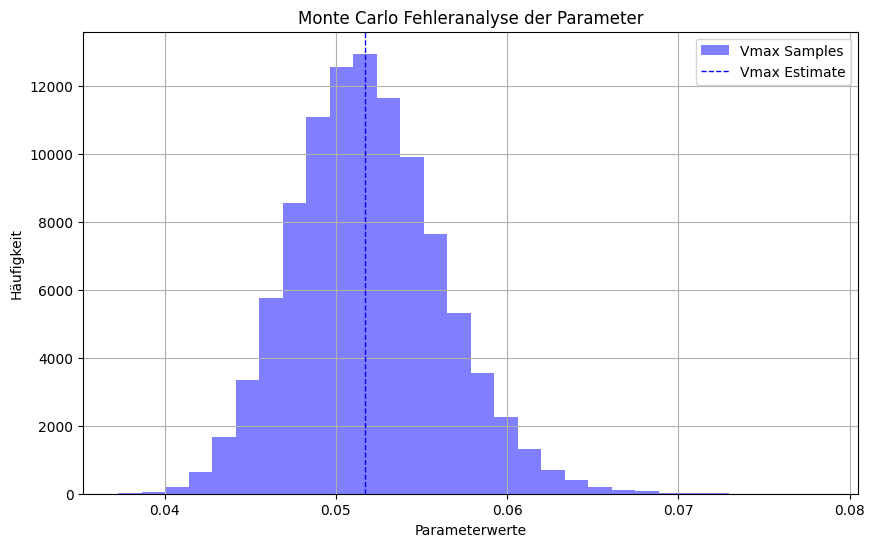

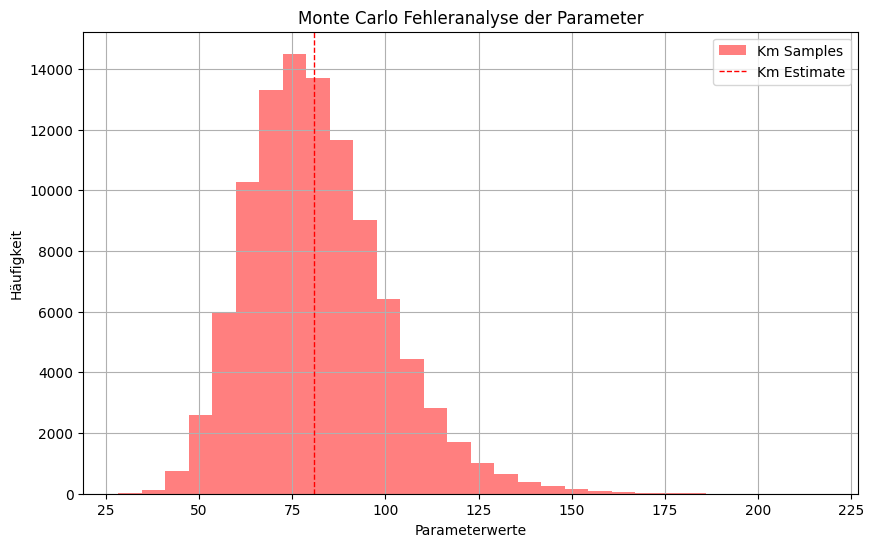

In [7]:
# Fehleranalyse mit Monte Carlo

n_samples = 100000

params_samples1 = []
params_samples2 = []
# Monte Carlo Simulation für die erste Kurve
for i in range(n_samples):
    
    nad_sample = nad + np.random.normal(0, 0.1 * nad)
    v11_sample = v11 + np.random.normal(0, 0.1 * v11)

    pd_sample = pd + np.random.normal(0, 0.1 * pd)
    v12_sample = v12 + np.random.normal(0, 0.1 * v12)
    
    params_sample1, _ = curve_fit(mm_equation, nad_sample, v11_sample, p0=[1.0, 1.0])
    params_samples1.append(params_sample1)

    params_sample2, _ = curve_fit(mm_equation, pd_sample, v12_sample, p0=[1.0, 1.0])
    params_samples2.append(params_sample2)


# Konvertiere in ein numpy Array
params_samples1 = np.array(params_samples1)
params_samples2 = np.array(params_samples2)

# Berechne die Standardabweichungen der geschätzten Parameter
vmax_samples1 = params_samples1[:, 0]
km_samples1 = params_samples1[:, 1]
vmax_std1 = np.std(vmax_samples1)
km_std1 = np.std(km_samples1)

vmax_samples2 = params_samples2[:, 0]
km_samples2 = params_samples2[:, 1]
vmax_std2 = np.std(vmax_samples2)
km_std2 = np.std(km_samples2)

# Ergebnisse anzeigen
print(f"\nMonte Carlo Fehleranalyse:")
print(f"Vmax = {vmax_est1:.4f} ± {vmax_std1:.4f}")
print(f"Km = {km_est1:.4f} ± {km_std1:.4f}")

print(f"Vmax = {vmax_est2:.4f} ± {vmax_std2:.4f}")
print(f"Km = {km_est2:.4f} ± {km_std2:.4f}")


# Plot der Monte Carlo Ergebnisse
plt.figure(figsize=(10, 6))
plt.hist(vmax_samples1, bins=30, alpha=0.5, label='Vmax Samples', color='blue')
plt.axvline(vmax_est1, color='blue', linestyle='dashed', linewidth=1, label='Vmax Estimate')
plt.xlabel('Parameterwerte')
plt.ylabel('Häufigkeit')
plt.title('Monte Carlo Fehleranalyse der Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Plot der Monte Carlo Ergebnisse
plt.figure(figsize=(10, 6))
plt.hist(km_samples1, bins=30, alpha=0.5, label='Km Samples', color='red')
plt.axvline(km_est1, color='red', linestyle='dashed', linewidth=1, label='Km Estimate')
plt.xlabel('Parameterwerte')
plt.ylabel('Häufigkeit')
plt.title('Monte Carlo Fehleranalyse der Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Plot der Monte Carlo Ergebnisse
plt.figure(figsize=(10, 6))
plt.hist(vmax_samples2, bins=30, alpha=0.5, label='Vmax Samples', color='blue')
plt.axvline(vmax_est2, color='blue', linestyle='dashed', linewidth=1, label='Vmax Estimate')
plt.xlabel('Parameterwerte')
plt.ylabel('Häufigkeit')
plt.title('Monte Carlo Fehleranalyse der Parameter')
plt.legend()
plt.grid(True)
plt.show()

# Plot der Monte Carlo Ergebnisse
plt.figure(figsize=(10, 6))
plt.hist(km_samples2, bins=30, alpha=0.5, label='Km Samples', color='red')
plt.axvline(km_est2, color='red', linestyle='dashed', linewidth=1, label='Km Estimate')
plt.xlabel('Parameterwerte')
plt.ylabel('Häufigkeit')
plt.title('Monte Carlo Fehleranalyse der Parameter')
plt.legend()
plt.grid(True)
plt.show()